In [119]:
import pandas as pd
import numpy as np
import os

In [167]:
results_dir = "[3] Test Input"

output_dir = "[5] Tester Results"
os.makedirs(output_dir, exist_ok=True)

recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

size = (10, 5)

In [121]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

all_experiments = set()
for df in dfs.values():
    if 'experiment' in df.columns:
        all_experiments.update(df['experiment'].dropna().unique())

experiments = sorted(all_experiments)
print(f"All experiments found across raw dataframes ({len(experiments)}):")
print(" " + ', '.join(map(str, experiments)))

# ...existing code...

Raw dataframes: ['RESULTS', 'RESULTS_ASR_control', 'RESULTS_MERGED', 'RESULTS_MERGED_ASR_control', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_DATE_ASR_control', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MT10_ASR_control', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_ASR_control', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE_ASR_control', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_T10_ASR_control', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_ASR_control', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE_ASR_control', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder', 'SegmentOrder_ASR_control']
Fit dataframes: []
Found 23 raw and 0 fit dataframes in [3] Test Input.

Found 1 experiments, 6 variables and 4 parameters:
 ASR_control
 reactionTime, peakValue, PTPA, PTTA, RMS, AUC
 animal, sex, date, experiment
All experiments found across raw dataframes (19):
 ASR_control, gap_depth, gap_duration_10, gap_duration_20, gap_duration_4, gap_duration_50, gap_duration_8, offset_ASR, offset_PPI_10, 

---

## Average Reaction Time

In [122]:
import pandas as pd
from scipy.stats import ttest_1samp, t
import numpy as np

df = dfs['RESULTS_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['reactionTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    n = len(filtered)
    mean = filtered.mean()
    sem = filtered.sem()
    # 95% confidence interval
    ci = t.interval(0.95, n-1, loc=mean, scale=sem) if n > 1 else (np.nan, np.nan)
    print(f"\nSex: {sex}")
    print(f"Mean reaction time (IQR filtered): {mean:.2f}")
    print(f"95% CI: ({ci[0]:.2f}, {ci[1]:.2f})")
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Reaction time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Reaction time is significantly higher than 6.")
    else:
        print("Reaction time is not significantly higher than 6 or 8.")


Sex: female
Mean reaction time (IQR filtered): 29.47
95% CI: (29.06, 29.87)
T-test vs 8: statistic=105.403, p-value=1.092e-140
T-test vs 6: statistic=115.224, p-value=2.621e-146
Reaction time is significantly higher than 8.

Sex: male
Mean reaction time (IQR filtered): 23.59
95% CI: (22.91, 24.27)
T-test vs 8: statistic=45.426, p-value=1.228e-90
T-test vs 6: statistic=51.254, p-value=4.042e-98
Reaction time is significantly higher than 8.


---

## Repetition Differences

In [123]:
# ...existing code...

def test_repetition_effect_per_animal_date_experiment(df, variables, max_reps=5, alpha=0.05):
    
    import ast
    from scipy.stats import f_oneway, kruskal, shapiro
    import numpy as np
    import pandas as pd

    all_rep_vals = []
    for (animal, date, experiment), group in df.groupby(['animal', 'date', 'experiment']):
        for var in variables:
            vals = group[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
            list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
            if list_rows.empty:
                continue
            min_len = min(list_rows.apply(len))
            min_len = min(min_len, max_reps)
            for i in range(min_len):
                group_vals = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
                if len(group_vals) > 1:
                    all_rep_vals.append(group_vals.values)
    normal = True
    for group_vals in all_rep_vals:
        if len(group_vals) > 2:
            stat_sw, p_sw = shapiro(group_vals)
            if p_sw < 0.05:
                normal = False
                break
    results = []
    for (animal, date, experiment), group in df.groupby(['animal', 'date', 'experiment']):
        for var in variables:
            vals = group[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
            list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
            if list_rows.empty:
                continue
            min_len = min(list_rows.apply(len))
            min_len = min(min_len, max_reps)
            rep_groups = []
            for i in range(min_len):
                group_vals = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
                if len(group_vals) > 1:
                    rep_groups.append(group_vals.values)
            if len(rep_groups) < 2:
                continue
            if normal:
                stat, p = f_oneway(*rep_groups)
                test_type = 'anova'
            else:
                stat, p = kruskal(*rep_groups)
                test_type = 'kruskal'
            if p < alpha:
                mean_diff = np.mean(rep_groups[0]) - np.mean(rep_groups[-1])
                vals1 = rep_groups[0]
                vals2 = rep_groups[-1]
                pooled_std = ((np.std(vals1, ddof=1) ** 2 + np.std(vals2, ddof=1) ** 2) / 2) ** 0.5
                effect_strength = mean_diff / pooled_std if pooled_std != 0 else np.nan
                results.append({
                    'animal': animal,
                    'date': date,
                    'experiment': experiment,
                    'variable': var,
                    'stat': stat,
                    'p': p,
                    'test': test_type,
                    'mean_diff': mean_diff,
                    'effect_strength': effect_strength
                })
    return pd.DataFrame(results)

repetition_effects_per_animal_date_exp = test_repetition_effect_per_animal_date_experiment(dfs['RESULTS'], variables)
# ...existing code...
if repetition_effects_per_animal_date_exp.empty:
    print("No significant repetition differences found in any group.")
else:
    sig_repetition_effects_exp = repetition_effects_per_animal_date_exp[repetition_effects_per_animal_date_exp['p'] < 0.05]
    print("Significant repetition differences found in the following animal/date/experiment/variable groups:")
    print(sig_repetition_effects_exp[['animal', 'date', 'experiment', 'variable', 'mean_diff', 'effect_strength', 'test', 'p']])
    sig_repetition_effects_exp.to_excel(os.path.join(output_dir, "REPETITION_EFFECTS_PER_ANIMAL_DATE_EXPERIMENT_SIGNIFICANT.xlsx"), index=False)
# ...existing code...

No significant repetition differences found in any group.


In [124]:
# ...existing code...

def test_repetition_effect_merged_experiment(df, variables, max_reps=5, alpha=0.05):
    """
    Merge across animals and test repetition effects per (date, experiment).
    Returns DataFrame with significant results (p < alpha) for each date/experiment/variable.
    """
    import ast
    import numpy as np
    import pandas as pd
    from scipy.stats import f_oneway, kruskal, shapiro

    results = []
    for (date, experiment), group in df.groupby(['date', 'experiment']):
        for var in variables:
            # parse list-like cells, keep only rows that contain lists of repetitions
            vals = group[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
            list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
            if list_rows.empty:
                continue

            # determine how many repetition positions to test (limit by max_reps)
            min_len = min(list_rows.apply(len))
            min_len = min(min_len, max_reps)

            # build groups for each repetition index (pooled across animals)
            rep_groups = []
            for i in range(min_len):
                group_vals = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
                if len(group_vals) > 1:
                    rep_groups.append(group_vals.values)

            if len(rep_groups) < 2:
                continue

            # decide normality across repetition groups (if any group of length>2 fails Shapiro => non-normal)
            normal = True
            for g in rep_groups:
                if len(g) > 2:
                    _, p_sw = shapiro(g)
                    if p_sw < 0.05:
                        normal = False
                        break

            # run appropriate test
            if normal:
                stat, p = f_oneway(*rep_groups)
                test_type = 'anova'
            else:
                stat, p = kruskal(*rep_groups)
                test_type = 'kruskal'

            if p < alpha:
                mean_diff = np.mean(rep_groups[0]) - np.mean(rep_groups[-1])
                vals1 = rep_groups[0]
                vals2 = rep_groups[-1]
                pooled_std = ((np.std(vals1, ddof=1) ** 2 + np.std(vals2, ddof=1) ** 2) / 2) ** 0.5
                effect_strength = mean_diff / pooled_std if pooled_std != 0 else np.nan
                results.append({
                    'date': date,
                    'experiment': experiment,
                    'variable': var,
                    'stat': stat,
                    'p': p,
                    'test': test_type,
                    'mean_diff': mean_diff,
                    'effect_strength': effect_strength
                })

    return pd.DataFrame(results)


# run merged-per-experiment repetition test
repetition_effects_merged_exp = test_repetition_effect_merged_experiment(dfs['RESULTS'], variables)

if repetition_effects_merged_exp.empty:
    print("No significant repetition differences found when merged across animals per (date, experiment).")
else:
    sig_repetition_effects_merged = repetition_effects_merged_exp[repetition_effects_merged_exp['p'] < 0.05]
    print("Significant repetition differences (merged across animals) for date / experiment / variable:")
    print(sig_repetition_effects_merged[['date', 'experiment', 'variable', 'mean_diff', 'effect_strength', 'test', 'p']])
    sig_repetition_effects_merged.to_excel(os.path.join(output_dir, "REPETITION_EFFECTS_MERGED_EXPERIMENT_SIGNIFICANT.xlsx"), index=False)

# ...existing code...

No significant repetition differences found when merged across animals per (date, experiment).


# ---> merge across repetitions

---

## Intratrial Differences

In [125]:
import pandas as pd
from scipy.stats import linregress

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date']]
trend_results = []

for (animal, experiment, date), group in df.groupby(['animal', 'experiment', 'date']):
    order = range(len(group))
    for var in variables:
        vals = group[var].dropna()
        if len(vals) > 1:
            slope, intercept, r, p, _ = linregress(order[:len(vals)], vals)
            start = vals.iloc[0]
            end = vals.iloc[-1]
            percent_change = ((end - start) / start) * 100 if start != 0 else None
            trend_results.append({
                'animal': animal,
                'experiment': experiment,
                'date': date,
                'variable': var,
                'slope_per_trial': slope,
                'r': r,
                'p': p,
                'direction': 'increase' if slope > 0 else 'decrease' if slope < 0 else 'none',
                'percent_change': percent_change
            })

trend_df = pd.DataFrame(trend_results)
if not trend_df.empty and 'p' in trend_df.columns:
    trend_df = trend_df[trend_df['p'] < 0.05].reset_index(drop=True)  # Only keep significant results
else:
    print("No significant intratrial differences found.")
    trend_df = pd.DataFrame()  # Empty DataFrame
trend_df.to_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT_ANIMAL_EXPERIMENT.xlsx"), index=False)

No significant intratrial differences found.


In [126]:
import pandas as pd
from scipy.stats import linregress

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date']]
trend_results = []

for (animal, experiment, date), group in df.groupby(['animal', 'experiment', 'date']):
    order = range(len(group))
    for var in variables:
        vals = group[var].dropna()
        if len(vals) > 1:
            slope, intercept, r, p, _ = linregress(order[:len(vals)], vals)
            start = vals.iloc[0]
            end = vals.iloc[-1]
            percent_change = ((end - start) / start) * 100 if start != 0 else None
            trend_results.append({
                'animal': animal,
                'experiment': experiment,
                'date': date,
                'variable': var,
                'slope_per_trial': slope,
                'r': r,
                'p': p,
                'direction': 'increase' if slope > 0 else 'decrease' if slope < 0 else 'none',
                'percent_change': percent_change
            })

trend_df = pd.DataFrame(trend_results)
if not trend_df.empty and 'p' in trend_df.columns:
    trend_df = trend_df[trend_df['p'] < 0.05].reset_index(drop=True)  # Only keep significant results
else:
    print("No significant intratrial differences found.")
    trend_df = pd.DataFrame()  # Empty DataFrame
trend_df.to_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT_ANIMAL_EXPERIMENT.xlsx"), index=False)

No significant intratrial differences found.


---

In [127]:
import pandas as pd
import statsmodels.formula.api as smf

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
for var in variables:
    print(f"\n=== Mixed Linear Model for {var} ===")
    try:
        model = smf.mixedlm(f'{var} ~ C(sex) + C(date) + C(experiment)', data=df, groups=df['animal']).fit()
        print(model.summary())
    except Exception as e:
        print(f"Could not fit model for {var}: {e}")


=== Mixed Linear Model for reactionTime ===
                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      reactionTime
No. Observations:        306          Method:                  REML        
No. Groups:              6            Scale:                   9.2823      
Min. group size:         51           Log-Likelihood:          -759.4552   
Max. group size:         51           Converged:               Yes         
Mean group size:         51.0                                              
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        27.914    1.021 27.333 0.000 25.913 29.916
C(sex)[T.male]                   -5.575    0.997 -5.592 0.000 -7.529 -3.621
C(date)[T.June26]                -2.766    0.427 -6.484 0.000 

# Summary of Mixed Linear Model Results

### Reaction Metrics
- **reactionTime**
  - **Sex:** No significant effect.
  - **Date:** Both June26 and May20 are significantly lower than the reference (p < 0.001).
  - **Experiment:** Most not significant, but offset_PPI_14, _20, _6, _8 show significantly higher reactionTime (p < 0.05). tone_in_noise is significantly lower (p = 0.002).
- **peakTime & difference**
  - No significant effects for sex, date, or experiment.

### Strength Metrics (peakValue, PTPA, PTTA, RMS, AUC)
- **Sex:** Males have significantly higher values for all except tau and AUC (p < 0.05).
- **Date:** Both June26 and May20 are significantly higher than the reference (p < 0.001).
- **Experiment:** offset_PPI variants and tone_in_noise are significantly lower (p < 0.05 for many variants). Other experiments mostly not significant.

### tau
- **Sex:** Males have significantly lower tau (p = 0.017).
- **Date:** May20 is significantly lower than reference (p = 0.002).
- **Experiment:** No significant effects.

### Summary
- Sex and date strongly affect strength metrics, but not reaction metrics.
- offset_PPI and tone_in_noise experiments consistently reduce strength metrics and reactionTime.
- peakTime and difference are not significantly affected by any factor.

# ---> reaction time is the best reaction metric
# ---> AUC might be useful for avoiding sex differences
# ---> males have higher strength
# ---> recording date affects strength most
# ---> especially tone in noise and offset PPI cause lower ASR strength (in line with %PPI results)
# ---> tau varies by sex and date, much like strength, but unlike strength is not affected by experiment

---

## Sex Differences

In [128]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import os

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
sex_diff_results = []

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for var in variables:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        mean_diff = vals_male.mean() - vals_female.mean() if len(vals_male) > 0 and len(vals_female) > 0 else None
        # Shapiro normality test for both groups
        normal_male = len(vals_male) > 2 and shapiro(vals_male)[1] > 0.05
        normal_female = len(vals_female) > 2 and shapiro(vals_female)[1] > 0.05
        if len(vals_male) > 1 and len(vals_female) > 1:
            if normal_male and normal_female:
                stat, p = ttest_ind(vals_male, vals_female, equal_var=False)
                test_type = 'ttest_ind'
            else:
                stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
                test_type = 'mannwhitneyu'
            # Cohen's d for effect size
            pooled_std = ((vals_male.std(ddof=1) ** 2 + vals_female.std(ddof=1) ** 2) / 2) ** 0.5
            eff = mean_diff / pooled_std if pooled_std != 0 else None
        else:
            stat, p, eff, test_type = None, None, None, None
        sex_diff_results.append({
            'date': date,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'effect_strength': eff,
            'mean_diff': mean_diff,
            'test': test_type
        })

test_sex_shapiro = pd.DataFrame(sex_diff_results)
sig_sex = test_sex_shapiro[test_sex_shapiro['significant']]
print(sig_sex)
sig_sex.to_excel(os.path.join(output_dir, "TEST_SEX_SHAPIRO_SIGNIFICANT.xlsx"), index=False)

       date      variable         stat             p  significant  \
0   April16  reactionTime   373.000000  5.100012e-10         True   
1   April16     peakValue  2584.500000  8.638843e-18         True   
2   April16          PTPA    15.977557  3.854158e-24         True   
3   April16          PTTA    15.203717  2.830349e-23         True   
4   April16           RMS  2590.000000  6.303738e-18         True   
5   April16           AUC  2574.000000  1.598064e-17         True   
6    June26  reactionTime   318.500000  4.896718e-11         True   
7    June26     peakValue  2451.000000  1.395534e-14         True   
8    June26          PTPA  2431.000000  3.946074e-14         True   
9    June26          PTTA  2428.000000  4.604058e-14         True   
10   June26           RMS  2360.000000  1.364803e-12         True   
11   June26           AUC  2477.000000  3.528772e-15         True   
12    May20  reactionTime   346.000000  1.582815e-10         True   
13    May20     peakValue    15.54

All metrics show highly significant sex differences (p-values << 0.05) for every date.
Strength metrics (peakValue, PTPA, PTTA, RMS, AUC):
Males have much higher values than females (large positive mean_diff, effect_strength > 2).
Effect sizes (Cohen's d) are very large, indicating robust differences.
Reaction time:
Females have lower reaction times (negative mean_diff, large negative effect_strength), meaning they respond faster.
Test type:
Mann-Whitney U used when normality fails (most cases).
t-test used when both groups pass Shapiro normality (some cases).
Consistency:
The pattern is stable across all dates (April16, June26, May20).
Summary:

Sex is a major determinant of ASR strength and reaction time.
Males consistently show stronger ASR responses; females respond faster.
These differences are robust, large, and repeatable across dates and metrics.

In [129]:
import pandas as pd
import os

# Use the correct file: TEST_SEX_SHAPIRO_SIGNIFICANT.xlsx
df = pd.read_excel(os.path.join(output_dir, "TEST_SEX_SHAPIRO_SIGNIFICANT.xlsx"))

# Only keep numeric columns for averaging
cols_to_avg = ['stat', 'p', 'effect_strength', 'mean_diff']
avg_df = df.groupby('variable')[cols_to_avg].mean().reset_index()

# Optionally, keep the first test type for each variable
avg_df['test'] = df.groupby('variable')['test'].first().values

print(avg_df)
avg_df.to_excel(os.path.join(output_dir, "TEST_SEX_AVG_ACROSS_DATES_SHAPIRO.xlsx"), index=False)

       variable         stat             p  effect_strength    mean_diff  \
0           AUC  1689.274327  1.181584e-15         2.929926  1188.331558   
1          PTPA   820.740873  1.315358e-14         2.780553    35.003178   
2          PTTA   819.133090  1.534686e-14         2.652570    31.623188   
3           RMS  1655.018908  4.549364e-13         2.762041    12.210746   
4     peakValue  1683.682071  4.654659e-15         2.824072    36.860240   
5  reactionTime   345.833333  2.390833e-10        -1.653877    -5.575381   

           test  
0  mannwhitneyu  
1     ttest_ind  
2     ttest_ind  
3  mannwhitneyu  
4  mannwhitneyu  
5  mannwhitneyu  


Saved PGF: C:\Users\Galahad\Desktop\Thesis\images\sex.pgf


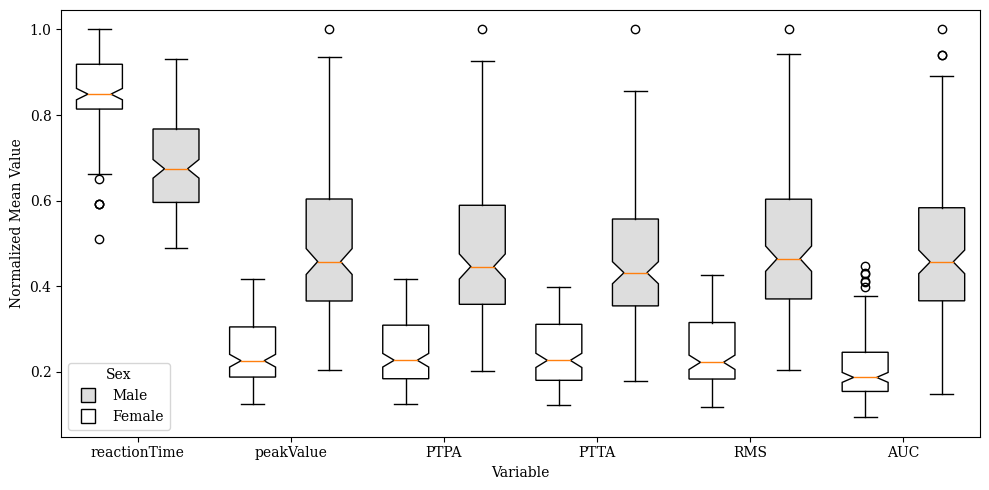

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

df = dfs['RESULTS_MERGED']


# Get all unique sexes and variables
sexes = df['sex'].unique()


# Prepare data for boxplot: raw values for each variable/sex, EXCLUDE negative values
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, sex in enumerate(sexes):
        vals = df[df['sex'] == sex][var].dropna()
        vals = vals[vals >= 0]  # Exclude negative values
        # Normalize to [-1, 1] for each variable
        max_abs = np.max(np.abs(df[var].dropna()))
        vals_norm = vals / max_abs if max_abs != 0 else vals
        data.append(vals_norm)
        positions.append(i * 2 + j)
        labels.append(f"{var}" if j == 0 else "")  # Only label once per variable
        box_colors.append('#DDDDDD' if sex == 'male' else '#FFFFFF')  # Gray for male, white for female

plt.figure(figsize=size)
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks([i * 2 + 0.5 for i in range(len(variables))], variables)
plt.ylabel('Normalized Mean Value')
plt.xlabel('Variable')
plt.legend(handles=[
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#DDDDDD', label='Male', linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#FFFFFF', label='Female', linestyle='None')
], title='Sex', loc='lower left')
# ...existing code...
plt.tight_layout()

# Save PGF (with PDF fallback)
import matplotlib as mpl
import os

export_folder = r"C:\Users\Galahad\Desktop\Thesis\images"
os.makedirs(export_folder, exist_ok=True)

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": False,
    "pgf.rcfonts": False,
})

fig = plt.gcf()
pgf_path = os.path.join(export_folder, "sex.pgf")
pdf_path = os.path.join(export_folder, "sex.pdf")
try:
    fig.savefig(pgf_path, format="pgf", bbox_inches="tight")
    print(f"Saved PGF: {pgf_path}")
except Exception as e:
    print(f"PGF save failed ({e}), saving PDF instead.")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved PDF: {pdf_path}")

plt.show()
# ...existing code...

---

## Experiment Differences

In [131]:
import pandas as pd
from scipy.stats import f_oneway, kruskal, shapiro
import scikit_posthocs as sp
import os

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for var in variables:
            valid_exps = [exp for exp in df_sub['experiment'].unique()
                          if df_sub[df_sub['experiment'] == exp][var].dropna().shape[0] > 1]
            if len(valid_exps) < 2:
                continue
            groups = [df_sub[df_sub['experiment'] == exp][var].dropna().values for exp in valid_exps]
            normal = True
            for vals in groups:
                if len(vals) > 2:
                    stat_sw, p_sw = shapiro(vals)
                    if p_sw < 0.05:
                        normal = False
                        break
            stat, p, posthoc_p, posthoc_test, exp1, exp2, eff, mean_diff = None, None, None, None, None, None, None, None
            if len(groups) > 1:
                if normal:
                    stat, p = f_oneway(*groups)
                    test_type = 'ANOVA'
                    posthoc_func = sp.posthoc_tukey_hsd
                else:
                    stat, p = kruskal(*groups)
                    test_type = 'Kruskal-Wallis'
                    posthoc_func = sp.posthoc_dunn
                if p is not None and p < 0.05:
                    try:
                        posthoc = posthoc_func(df_sub[df_sub['experiment'].isin(valid_exps)],
                                               val_col=var, group_col='experiment')
                        min_p = posthoc.replace(0, float('nan')).min().min()
                        idx = posthoc.stack().idxmin()
                        exp1, exp2 = idx
                        vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                        vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                        mean_diff = vals1.mean() - vals2.mean()
                        pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                        eff = mean_diff / pooled_std if pooled_std != 0 else None
                        posthoc_p = min_p
                        posthoc_test = posthoc_func.__name__
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, posthoc_func.__name__, None
                    results.append({
                        'sex': sex, 'date': date, 'variable': var,
                        'test': test_type,
                        'stat': stat, 'p': p,
                        'posthoc_p': posthoc_p, 'posthoc_test': posthoc_test,
                        'exp1': exp1, 'exp2': exp2,
                        'effect_strength': eff, 'mean_diff': mean_diff
                    })

test_experiment_shapiro = pd.DataFrame(results)
print(test_experiment_shapiro)
test_experiment_shapiro.to_excel(os.path.join(output_dir, "TEST_EXPERIMENT_ALL_VARIABLES_SHAPIRO_SIGNIFICANT.xlsx"), index=False)

      sex   date      variable            test       stat        p  posthoc_p  \
0  female  May20  reactionTime  Kruskal-Wallis  28.997948  0.02395   0.001275   

   posthoc_test             exp1           exp2  effect_strength  mean_diff  
0  posthoc_dunn  gap_duration_10  offset_PPI_12        -3.514231  -5.733333  


---> no overall effect, can pool

In [132]:
# ...existing code...
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

df = dfs['RESULTS_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    print(f"\nSex: {sex} (dates merged)")
    for metric in metrics:
        for i, exp1 in enumerate(experiments):
            for exp2 in experiments[i+1:]:
                vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                if len(vals1) > 2 and len(vals2) > 2:
                    p_sw1 = shapiro(vals1)[1]
                    p_sw2 = shapiro(vals2)[1]
                    normal = p_sw1 > 0.05 and p_sw2 > 0.05
                    if normal:
                        stat, p = ttest_ind(vals1, vals2, equal_var=False)
                        test_type = 'ttest_ind'
                    else:
                        stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        test_type = 'mannwhitneyu'

                    # mean difference and effect strength (Cohen-like) —
                    mean_diff = vals1.mean() - vals2.mean()
                    pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                    effect_strength = mean_diff / pooled_std if pooled_std != 0 else None
                    eff_str = f"{effect_strength:.3f}" if effect_strength is not None else "N/A"

                    if p < 0.05:
                        print(f"  {metric}: {exp1} vs {exp2} | {test_type} p={p:.3e} (Shapiro p1={p_sw1:.3e}, p2={p_sw2:.3e}) mean_diff={mean_diff:.3f}, effect_strength={eff_str}")
# ...existing code...


Sex: female (dates merged)
  reactionTime: gap_depth vs tone_in_noise | mannwhitneyu p=3.974e-03 (Shapiro p1=2.899e-01, p2=4.127e-03) mean_diff=-3.267, effect_strength=-1.596
  reactionTime: gap_depth vs offset_PPI_4 | ttest_ind p=8.087e-03 (Shapiro p1=2.899e-01, p2=6.788e-02) mean_diff=-2.944, effect_strength=-1.455
  reactionTime: gap_depth vs offset_PPI_8 | mannwhitneyu p=2.094e-02 (Shapiro p1=2.899e-01, p2=4.994e-03) mean_diff=-2.300, effect_strength=-1.133
  reactionTime: gap_depth vs offset_PPI_10 | mannwhitneyu p=3.532e-02 (Shapiro p1=2.899e-01, p2=1.506e-02) mean_diff=-2.622, effect_strength=-1.124
  reactionTime: gap_depth vs offset_PPI_12 | mannwhitneyu p=2.991e-02 (Shapiro p1=2.899e-01, p2=7.109e-04) mean_diff=-2.733, effect_strength=-0.940
  reactionTime: gap_depth vs offset_PPI_50 | ttest_ind p=5.022e-03 (Shapiro p1=2.899e-01, p2=4.627e-01) mean_diff=-3.122, effect_strength=-1.585
  reactionTime: tone_in_noise vs gap_duration_10 | mannwhitneyu p=1.285e-02 (Shapiro p1=4.12

In [133]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import re
import os

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def get_trailing_number(exp, prefix):
    match = re.match(rf"{prefix}_(\d+)", str(exp))
    return int(match.group(1)) if match else None

results = []

for prefix in ['gap_duration', 'offset_PPI']:
    exps = sorted([e for e in df['experiment'].unique() if e.startswith(prefix)])
    numbers = sorted({get_trailing_number(e, prefix) for e in exps if get_trailing_number(e, prefix) is not None})
    if len(numbers) < 2:
        continue
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex]
        for date in df['date'].unique():
            df_sex_date = df_sex[df_sex['date'] == date]
            for i, n1 in enumerate(numbers):
                for n2 in numbers[i+1:]:
                    exp1 = f"{prefix}_{n1}"
                    exp2 = f"{prefix}_{n2}"
                    for var in variables:
                        vals1 = df_sex_date[df_sex_date['experiment'] == exp1][var].dropna()
                        vals2 = df_sex_date[df_sex_date['experiment'] == exp2][var].dropna()
                        if len(vals1) > 2 and len(vals2) > 2:
                            p_sw1 = shapiro(vals1)[1]
                            p_sw2 = shapiro(vals2)[1]
                            normal = p_sw1 > 0.05 and p_sw2 > 0.05
                            if normal:
                                stat, p = ttest_ind(vals1, vals2, equal_var=False)
                                test_type = 'ttest_ind'
                            else:
                                stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                                test_type = 'mannwhitneyu'
                            mean_diff = vals1.mean() - vals2.mean()
                            results.append({
                                'prefix': prefix,
                                'sex': sex,
                                'date': date,
                                'variable': var,
                                'exp1': exp1,
                                'exp2': exp2,
                                'n1': n1,
                                'n2': n2,
                                'stat': stat,
                                'p': p,
                                'test': test_type,
                                'shapiro_p1': p_sw1,
                                'shapiro_p2': p_sw2,
                                'mean_diff': mean_diff,
                                'significant': p < 0.05
                            })

results_df = pd.DataFrame(results)
print("Significant effects of trailing number in gap_duration/offset_PPI on all variables:")
print(results_df[results_df['significant'] == True][['prefix', 'sex', 'date', 'variable', 'exp1', 'exp2', 'n1', 'n2', 'test', 'p', 'shapiro_p1', 'shapiro_p2', 'mean_diff']])

results_df.to_excel(os.path.join(output_dir, "TRAILING_NUMBER_EFFECT_GAP_OFFSET_ALL_VARIABLES.xlsx"), index=False)

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Significant effects of trailing number in gap_duration/offset_PPI on all variables:
           prefix     sex     date      variable             exp1  \
149  gap_duration  female    May20           AUC   gap_duration_8   
180  gap_duration    male  April16  reactionTime   gap_duration_4   
349  gap_duration    male    May20     peakValue  gap_duration_10   
350  gap_duration    male    May20          PTPA  gap_duration_10   
351  gap_duration    male    May20          PTTA  gap_duration_10   

                exp2  n1  n2       test         p  shapiro_p1  shapiro_p2  \
149  gap_duration_10   8  10  ttest_ind  0.003190    0.208419    0.849687   
180   gap_duration_8   4   8  ttest_ind  0.023563    0.816788    0.147822   
349  gap_duration_50  10  50  ttest_ind  0.008662    0.094436    0.388755   
350  gap_duration_50  10  50  ttest_ind  0.020225    0.833883    0.943860   
351  gap_duration_50  10  50  ttest_ind  0.025773    0.433000    0.600658   

      mean_diff  
149 -118.242167  
18

In [134]:
# ...existing code...
from scipy.stats import f_oneway, kruskal
# ...existing code...

for prefix in ['gap_duration', 'offset_PPI']:
    exps = sorted([e for e in df['experiment'].unique() if e.startswith(prefix)])
    numbers = sorted({get_trailing_number(e, prefix) for e in exps if get_trailing_number(e, prefix) is not None})
    if len(numbers) < 2:
        continue
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex]
        for date in df['date'].unique():
            df_sex_date = df_sex[df_sex['date'] == date]
            for var in variables:
                # collect groups for each trailing number
                groups = []
                group_ns = []
                for n in numbers:
                    exp = f"{prefix}_{n}"
                    vals = df_sex_date[df_sex_date['experiment'] == exp][var].dropna()
                    if len(vals) > 1:
                        groups.append(vals.values)
                        group_ns.append(n)
                if len(groups) < 2:
                    continue

                # check normality per group (if any group with len>2 fails -> non-normal)
                normal = True
                for g in groups:
                    if len(g) > 2:
                        if shapiro(g)[1] < 0.05:
                            normal = False
                            break

                if normal:
                    stat, p = f_oneway(*groups)
                    test_type = 'ANOVA'
                    # compute eta-squared (SS_between / SS_total)
                    all_vals = np.concatenate(groups)
                    grand_mean = np.mean(all_vals)
                    ss_between = sum(len(g) * (np.mean(g) - grand_mean) ** 2 for g in groups)
                    ss_total = sum((x - grand_mean) ** 2 for x in all_vals)
                    eta2 = ss_between / ss_total if ss_total != 0 else np.nan
                else:
                    stat, p = kruskal(*groups)
                    test_type = 'kruskal'
                    # approximate eta2 for Kruskal: H / (N - 1)
                    N = sum(len(g) for g in groups)
                    eta2 = stat / (N - 1) if (N - 1) != 0 else np.nan

                results.append({
                    'prefix': prefix,
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'n_groups': len(groups),
                    'groups': ','.join(map(str, group_ns)),
                    'stat': stat,
                    'p': p,
                    'test': test_type,
                    'eta2': eta2,
                    'significant': p < 0.05
                })
# ...existing code...


results_df = pd.DataFrame(results)
print("Significant effects of trailing number in gap_duration/offset_PPI on all variables:")
print(results_df[results_df['significant'] == True][['prefix', 'sex', 'date', 'variable', 'n_groups', 'groups', 'stat', 'p', 'test', 'eta2']])

results_df.to_excel(os.path.join(output_dir, "TRAILING_NUMBER_EFFECT_GAP_OFFSET_ALL_VARIABLES_ANOVA.xlsx"), index=False)

Significant effects of trailing number in gap_duration/offset_PPI on all variables:
           prefix     sex     date      variable  n_groups groups      stat  \
149  gap_duration  female    May20           AUC       NaN    NaN -6.663737   
180  gap_duration    male  April16  reactionTime       NaN    NaN  3.570283   
349  gap_duration    male    May20     peakValue       NaN    NaN -5.185361   
350  gap_duration    male    May20          PTPA       NaN    NaN -4.339907   
351  gap_duration    male    May20          PTTA       NaN    NaN -3.483200   

            p       test  eta2  
149  0.003190  ttest_ind   NaN  
180  0.023563  ttest_ind   NaN  
349  0.008662  ttest_ind   NaN  
350  0.020225  ttest_ind   NaN  
351  0.025773  ttest_ind   NaN  


---> gap duration increases strength sporadically

C:\Users\Galahad\AppData\Local\Temp\ipykernel_20344\1684519936.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Galahad\AppData\Local\Temp\ipykernel_20344\1684519936.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Saved PGF: C:\Users\Galahad\Desktop\Thesis\images\peakvalue.pgf


C:\Users\Galahad\AppData\Local\Temp\ipykernel_20344\1684519936.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\Galahad\AppData\Local\Temp\ipykernel_20344\1684519936.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([_sanitize(t) for t in xt])


Saved PGF: C:\Users\Galahad\Desktop\Thesis\images\reactiontime.pgf


C:\Users\Galahad\AppData\Local\Temp\ipykernel_20344\1684519936.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


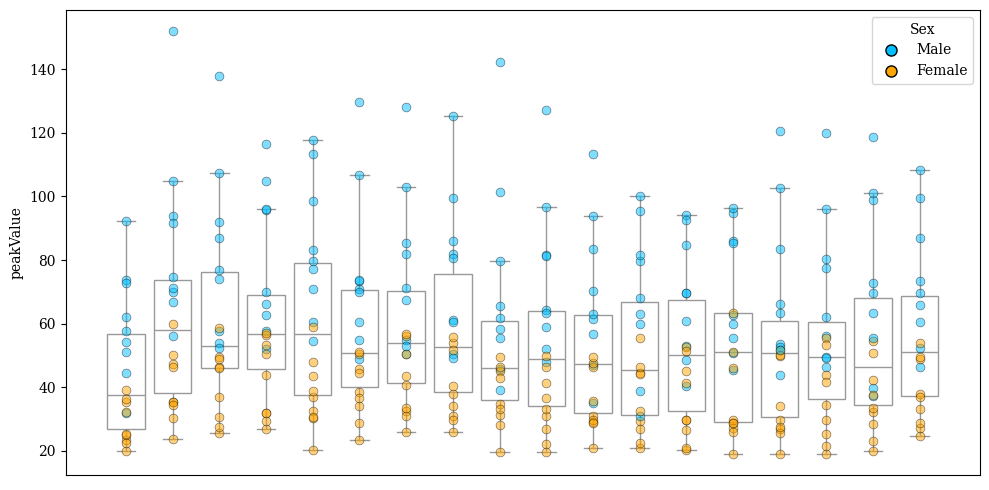

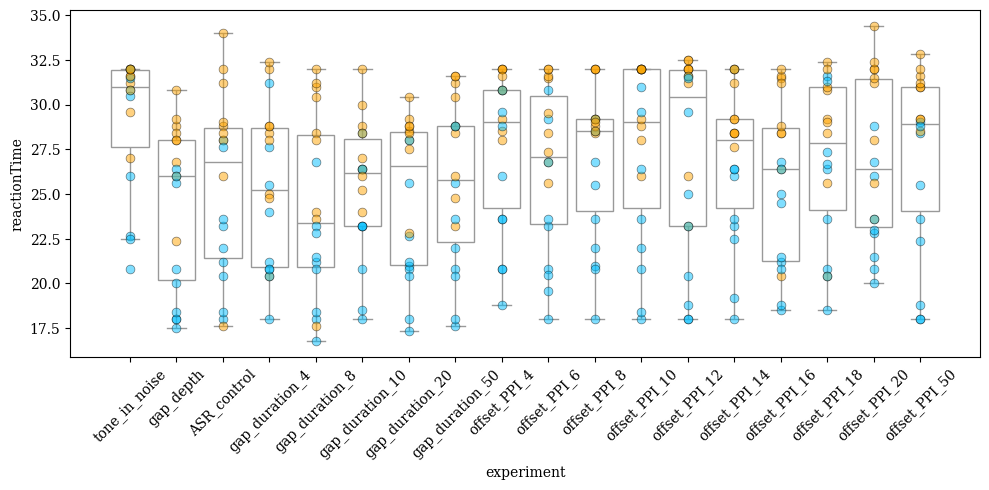

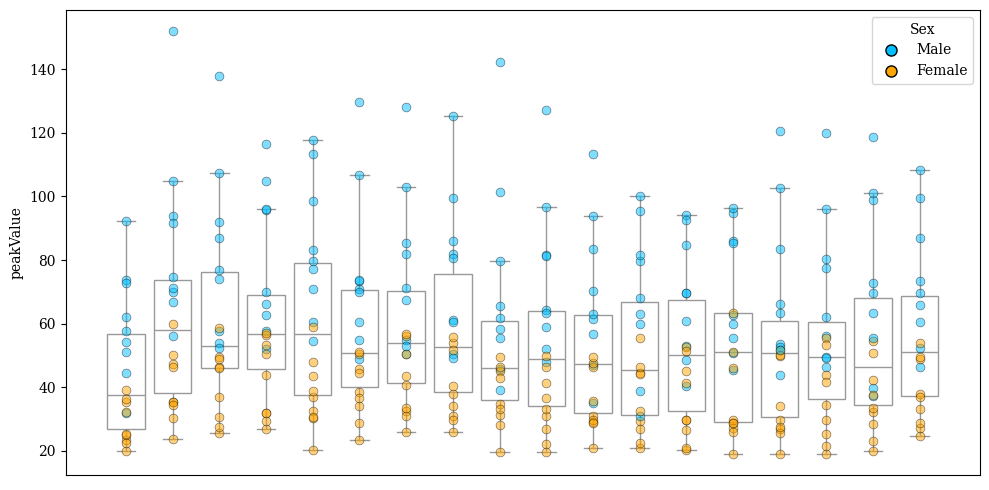

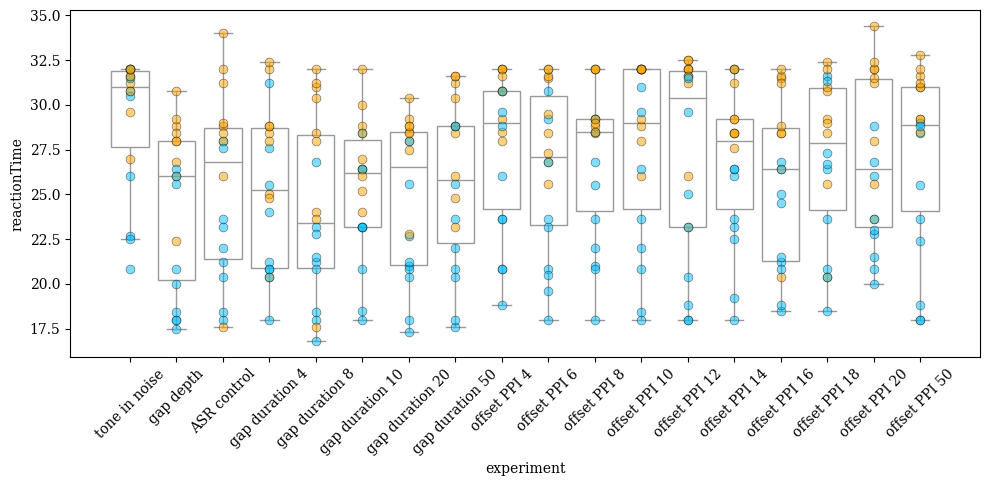

In [169]:
# ...existing code...
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_test_experiment_sex(df_main, output_dir, variable='peakValue', remove_xaxis=False, remove_legend=False, show=True):
    # Set experiment order: tone_in_noise before gap_depth, rest as found
    experiments = list(df_main['experiment'].unique())
    if 'tone_in_noise' in experiments and 'gap_depth' in experiments:
        experiments = [e for e in experiments if e not in ['tone_in_noise', 'gap_depth']]
        order = ['tone_in_noise', 'gap_depth'] + experiments
    else:
        order = experiments

    fig, ax = plt.subplots(figsize=size)
    # Boxplot with custom order (use the axis)
    sns.boxplot(data=df_main, x='experiment', y=variable, color='white', showfliers=False, zorder=1, order=order, ax=ax)

    # Scatterplot overlay: color code by sex (updated colors) and lower alpha
    color_map = {'male': 'deepskyblue', 'female': 'orange'}
    point_alpha = 0.5
    point_size = 40
    plotted_sexes = set()

    for _, row in df_main.iterrows():
        sex = row.get('sex', None)
        label = sex if (sex is not None and sex not in plotted_sexes) else None
        ax.scatter(
            x=row['experiment'],
            y=row[variable],
            color=color_map.get(sex, 'gray'),
            edgecolors='black',
            linewidths=0.5,
            alpha=point_alpha,
            marker='o',
            zorder=2,
            s=point_size,
            label=label
        )
        if label is not None:
            plotted_sexes.add(sex)

    ax.set_ylabel(variable)
    if not remove_xaxis:
        ax.set_xlabel('experiment')
        plt.setp(ax.get_xticklabels(), rotation=45)
    else:
        ax.set_xlabel('')
        ax.set_xticks([])

    if not remove_legend:
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor=color_map['male'], markeredgecolor='black', markersize=8),
            plt.Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor=color_map['female'], markeredgecolor='black', markersize=8)
        ]
        ax.legend(handles=handles, title='Sex', loc='best')

    fig.tight_layout()
    # save PNG via the figure (guaranteed correct figure)
    fig.savefig(os.path.join(output_dir, variable))

    if show:
        fig.show()
    return fig

import pandas as pd

# Load the correct file
df_main = pd.read_excel(r'[2] Analyzer Results/RESULTS_MERGED.xlsx')

# Use the plotting function with the loaded dataframe
plot_test_experiment_sex(df_main, output_dir, 'peakValue', remove_xaxis=True, remove_legend=False)
plot_test_experiment_sex(df_main, output_dir, 'reactionTime', remove_xaxis=False, remove_legend=True)


# ...existing code...
import matplotlib as mpl
import os

import matplotlib as mpl
import os

export_folder = r"C:\Users\Galahad\Desktop\Thesis\images"
os.makedirs(export_folder, exist_ok=True)

# ...existing code...
# ...existing code...
def save_fig_pgf_pdf(fig, basename):
    """Save provided Figure as PGF (fallback to PDF).
    Remove underscores from all text objects so LaTeX doesn't choke on them."""
    import os
    # sanitize function: replace underscores with space
    def _sanitize(s):
        return s.replace('_', ' ') if isinstance(s, str) and '_' in s else s

    # sanitize text in axes
    for ax in fig.axes:
        # axis labels & title
        ax.set_title(_sanitize(ax.get_title()))
        ax.set_xlabel(_sanitize(ax.get_xlabel()))
        ax.set_ylabel(_sanitize(ax.get_ylabel()))
        # tick labels (x and y)
        try:
            xt = [lbl.get_text() for lbl in ax.get_xticklabels()]
            if any('_' in t for t in xt):
                ax.set_xticklabels([_sanitize(t) for t in xt])
        except Exception:
            pass
        try:
            yt = [lbl.get_text() for lbl in ax.get_yticklabels()]
            if any('_' in t for t in yt):
                ax.set_yticklabels([_sanitize(t) for t in yt])
        except Exception:
            pass
        # legend texts
        leg = ax.get_legend()
        if leg is not None:
            for t in leg.get_texts():
                t.set_text(_sanitize(t.get_text()))

    # figure suptitle if present
    try:
        st = getattr(fig, "_suptitle", None)
        if st is not None:
            st.set_text(_sanitize(st.get_text()))
    except Exception:
        pass

    # redraw to apply text changes
    try:
        fig.canvas.draw()
    except Exception:
        pass

    pgf_path = os.path.join(export_folder, f"{basename}.pgf")
    pdf_path = os.path.join(export_folder, f"{basename}.pdf")
    # ensure PGF-friendly RC params
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": False,
        "pgf.rcfonts": False,
    })
    try:
        fig.savefig(pgf_path, format="pgf", bbox_inches="tight")
        print(f"Saved PGF: {pgf_path}")
    except Exception as e:
        print(f"PGF save failed ({e}), saving PDF instead.")
        fig.savefig(pdf_path, bbox_inches="tight")
        print(f"Saved PDF: {pdf_path}")
# ...existing code...

# Now call plotting and save reliably using the returned Figure
df_main = pd.read_excel(r'[2] Analyzer Results/RESULTS_MERGED.xlsx')

fig1 = plot_test_experiment_sex(df_main, output_dir, 'peakValue', remove_xaxis=True, remove_legend=False, show=False)
save_fig_pgf_pdf(fig1, "peakvalue")
fig1.show()

fig2 = plot_test_experiment_sex(df_main, output_dir, 'reactionTime', remove_xaxis=False, remove_legend=True, show=False)
save_fig_pgf_pdf(fig2, "reactiontime")
fig2.show()

---

## Date Differences

In [136]:
# ...existing code...

import pandas as pd
from scipy.stats import f_oneway, kruskal, shapiro
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

date_results_pooled_exp = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        # Pool all experiments, group by date
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        normal = True
        for g in groups:
            if len(g) > 2:
                stat_sw, p_sw = shapiro(g)
                if p_sw < 0.05:
                    normal = False
                    break
        stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
        if len(groups) > 1:
            if normal:
                stat, p = f_oneway(*groups)
                test_type = 'ANOVA'
                posthoc_func = sp.posthoc_tukey_hsd
            else:
                stat, p = kruskal(*groups)
                test_type = 'Kruskal-Wallis'
                posthoc_func = sp.posthoc_dunn
            if p is not None and p < 0.05:
                try:
                    posthoc = posthoc_func(df_sex, val_col=var, group_col='date')
                    min_p = posthoc.replace(0, float('nan')).min().min()
                    idx = posthoc.stack().idxmin()
                    date1, date2 = idx
                    vals1 = df_sex[df_sex['date'] == date1][var].dropna()
                    vals2 = df_sex[df_sex['date'] == date2][var].dropna()
                    mean_diff = vals1.mean() - vals2.mean()
                    pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                    eff = mean_diff / pooled_std if pooled_std != 0 else None
                    posthoc_p = min_p
                    posthoc_test = posthoc_func.__name__
                except Exception:
                    posthoc_p, posthoc_test, mean_diff = None, posthoc_func.__name__, None
        date_results_pooled_exp.append({
            'sex': sex,
            'variable': var,
            'test': test_type if len(groups) > 1 else None,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'date1': date1,
            'date2': date2,
            'effect_strength': eff,
            'mean_diff': mean_diff
        })

test_date_pooled_exp = pd.DataFrame(date_results_pooled_exp)
print(test_date_pooled_exp)

test_date_pooled_exp.to_excel(os.path.join(output_dir, "TEST_DATE_POOLED_EXPERIMENT.xlsx"), index=False)
# ...existing code...

       sex      variable            test       stat             p  \
0   female  reactionTime  Kruskal-Wallis  25.510877  2.886579e-06   
1   female     peakValue  Kruskal-Wallis  72.406019  1.893358e-16   
2   female          PTPA           ANOVA  60.273565  6.146453e-20   
3   female          PTTA  Kruskal-Wallis  65.417217  6.234933e-15   
4   female           RMS  Kruskal-Wallis  71.079209  3.675750e-16   
5   female           AUC  Kruskal-Wallis  83.121337  8.921359e-19   
6     male  reactionTime  Kruskal-Wallis  19.908049  4.753593e-05   
7     male     peakValue  Kruskal-Wallis  53.377997  2.565164e-12   
8     male          PTPA  Kruskal-Wallis  53.579792  2.318975e-12   
9     male          PTTA  Kruskal-Wallis  55.389825  9.381068e-13   
10    male           RMS  Kruskal-Wallis  42.938497  4.742680e-10   
11    male           AUC  Kruskal-Wallis  41.559300  9.451758e-10   

    significant     posthoc_p       posthoc_test    date1   date2  \
0          True  7.675884e-07    

Saved PGF: C:\Users\Galahad\Desktop\Thesis\images\date.pgf


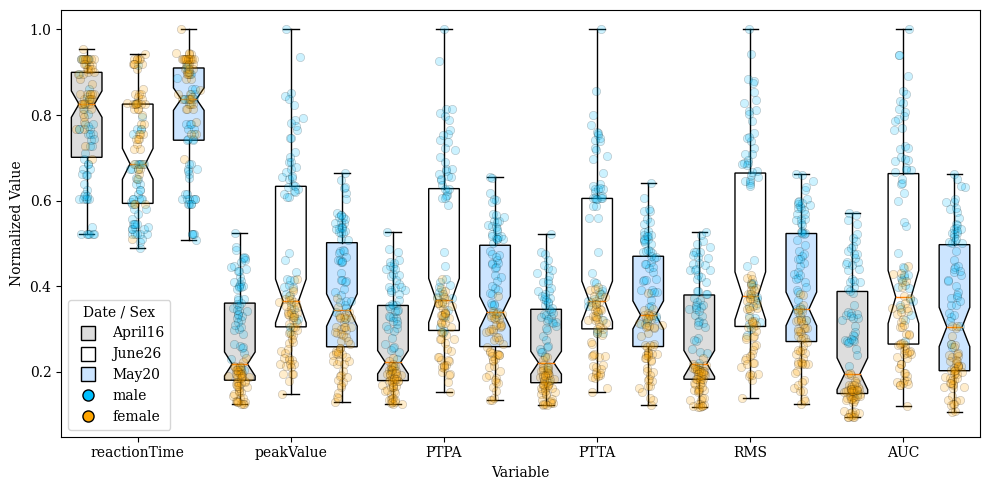

In [170]:
# ...existing code...

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load pooled experiment date results (significant only)
test_date_pooled = pd.read_excel(os.path.join(output_dir, "TEST_DATE_POOLED_EXPERIMENT.xlsx"))
df = dfs['RESULTS_MERGED']

# Only keep significant results
sig = test_date_pooled[test_date_pooled['significant'] == True]

# Get all unique dates and variables
dates = list(df['date'].unique())
variables = list(sig['variable'].unique())

# Color palette for dates (cycled if more than 5)
date_colors = ['#DDDDDD', '#FFFFFF', '#CCE5FF', '#FFCCCC', '#CCFFCC']
date_colors = [date_colors[i % len(date_colors)] for i in range(len(dates))]

# Prepare data for boxplot: raw values for each variable/date, EXCLUDE negative values
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    if var not in df.columns:
        continue
    col_nonzero = df[var].dropna()
    if col_nonzero.shape[0] == 0:
        continue
    max_abs = np.max(np.abs(col_nonzero)) if col_nonzero.size > 0 else 1
    for j, date in enumerate(dates):
        vals = df[df['date'] == date][var].dropna()
        vals = vals[vals >= 0]  # Exclude negative values
        if vals.empty:
            data.append([])            # keep positions aligned (matplotlib will ignore empty)
        else:
            vals_norm = vals / max_abs if max_abs != 0 else vals
            data.append(vals_norm)
        positions.append(i * len(dates) + j)
        labels.append(f"{var}" if j == 0 else "")
        box_colors.append(date_colors[j])

plt.figure(figsize=size)
# Create boxplot (matplotlib ignores empty lists in data)
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp.get('boxes', []), box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

# Overlay individual points, colored by sex
color_map = {'male': 'deepskyblue', 'female': 'orange'}
plotted_sexes = set()
jitter_scale = 0.08
point_alpha = 0.2
point_size = 36

for i, var in enumerate(variables):
    if var not in df.columns:
        continue
    col_nonzero = df[var].dropna()
    if col_nonzero.shape[0] == 0:
        continue
    max_abs = np.max(np.abs(col_nonzero)) if col_nonzero.size > 0 else 1
    for j, date in enumerate(dates):
        pos = i * len(dates) + j
        rows = df[df['date'] == date][[var, 'sex']].dropna(subset=[var])
        rows = rows[rows[var] >= 0]
        if rows.empty:
            continue
        # normalized values consistent with boxplot
        rows = rows.copy()
        rows['val_norm'] = rows[var] / max_abs if max_abs != 0 else rows[var]
        for sex, color in color_map.items():
            srows = rows[rows['sex'] == sex]
            if srows.empty:
                continue
            x = np.random.normal(loc=pos, scale=jitter_scale, size=srows.shape[0])
            label = sex if sex not in plotted_sexes else None
            plt.scatter(x, srows['val_norm'], color=color, edgecolor='black', linewidth=0.5,
                        alpha=point_alpha, label=label, zorder=5, s=point_size)
            if label is not None:
                plotted_sexes.add(sex)

# X ticks and labels
if len(dates) > 0 and len(variables) > 0:
    xticks = [i * len(dates) + (len(dates) - 1) / 2 for i in range(len(variables))]
    plt.xticks(xticks, variables)
plt.ylabel('Normalized Value')
plt.xlabel('Variable')

# Date legend handles
date_handles = []
for idx, d in enumerate(dates):
    # create square marker handle
    date_handles.append(plt.Line2D([0], [0], color='black', marker='s', markersize=10,
                                   markerfacecolor=date_colors[idx], linestyle='None', label=str(d)))
# Sex legend handles
sex_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['male'], markeredgecolor='black', markersize=8, label='male'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['female'], markeredgecolor='black', markersize=8, label='female')
]

# Combine legends (dates first)
handles = date_handles + sex_handles
plt.legend(handles=handles, title='Date / Sex', loc='lower left')

plt.tight_layout()


# ...existing code...
# ...existing code...
plt.tight_layout()
# export PGF/PDF for this figure (requires save_fig_pgf_pdf defined earlier in the notebook)
try:
    save_fig_pgf_pdf(plt.gcf(), "date")
except NameError:
    print("save_fig_pgf_pdf not found - define it earlier or re-run the cell that defines it.")
plt.show()
# ...existing code...

In [138]:
import pandas as pd

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date']]

# Calculate mean for each variable, grouped by date and sex
mean_table = df.groupby(['date', 'sex'])[variables].mean().reset_index()

print(mean_table)

# Optionally, save to Excel
mean_table.to_excel(os.path.join(output_dir, "MEAN_VARIABLES_BY_DATE_SEX.xlsx"), index=False)

      date     sex  reactionTime  peakValue       PTPA       PTTA        RMS  \
0  April16  female     29.749673  26.795098  26.373428  25.062134   8.427739   
1  April16    male     24.466667  55.488889  53.649225  50.092411  18.428065   
2   June26  female     27.317647  44.864706  44.050755  41.932267  14.735000   
3   June26    male     21.366013  91.174510  88.030708  82.082296  29.625748   
4    May20  female     30.423529  39.046078  38.409572  36.974223  12.540431   
5    May20    male     24.932026  74.623203  72.163355  66.663480  24.281595   

           AUC  
0   607.431271  
1  1606.305382  
2  1171.584049  
3  2599.928216  
4   840.967350  
5  1978.743745  


In [139]:
import pandas as pd

df = dfs['RESULTS_MERGED']
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'AUC']

# Calculate mean for each metric by date
mean_by_date = df.groupby('date')[strength_metrics].mean()

# Calculate mean difference between dates for each metric
mean_diff = mean_by_date.max() - mean_by_date.min()
mean_diff = mean_diff.rename('mean_difference')

# Combine for display
result = mean_by_date.T
result['mean_difference'] = mean_diff

print(result)

# Optionally save to Excel
result.to_excel(os.path.join(output_dir, "STRENGTH_METRIC_MEAN_DIFF_BY_DATE.xlsx"))

date           April16       June26        May20  mean_difference
peakValue    41.141993    68.019608    56.834641        26.877614
PTPA         40.011326    66.040732    55.286464        26.029405
PTTA         37.577273    62.007281    51.818851        24.430009
RMS          13.427902    22.180374    18.411013         8.752472
AUC        1106.868327  1885.756132  1409.855547       778.887806


In [140]:
# Calculate average effect strength for date differences, split by sex

import pandas as pd

# Load your results (replace with actual path if needed)
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE_POOLED_EXPERIMENT.xlsx"))

# Only keep significant results
sig = test_date[test_date['significant'] == True]

# Calculate average effect strength for each sex
avg_female = sig[sig['sex'] == 'female']['effect_strength'].mean()
avg_male = sig[sig['sex'] == 'male']['effect_strength'].mean()

# Calculate how much stronger the effect is for females
strength_ratio = avg_female / avg_male if avg_male != 0 else None
strength_diff = avg_female - avg_male

print(f"Average effect strength (female): {avg_female:.3f}")
print(f"Average effect strength (male): {avg_male:.3f}")
print(f"Females have {strength_ratio:.2f}x stronger effect on average (ratio), or {strength_diff:.3f} higher (difference).")

Average effect strength (female): -2.051
Average effect strength (male): -1.493
Females have 1.37x stronger effect on average (ratio), or -0.558 higher (difference).


# ---> split by date, especially for females (may be estrous cycle?)

---

## Recording Order Differences

In [141]:
# Test if recording order affects any variable, split by sex and date, pooled for experiment.
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []
for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        if df_sub.empty:
            continue
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                # Shapiro-Wilk normality test
                p_sw_early = shapiro(vals_early)[1] if len(vals_early) > 2 else 1.0
                p_sw_late = shapiro(vals_late)[1] if len(vals_late) > 2 else 1.0
                normal = p_sw_early > 0.05 and p_sw_late > 0.05
                if normal:
                    stat, p = ttest_ind(vals_early, vals_late, equal_var=False)
                    test_type = 'ttest_ind'
                else:
                    stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                    test_type = 'mannwhitneyu'
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'test': test_type,
                    'stat': stat,
                    'p': p,
                    'shapiro_p_early': p_sw_early,
                    'shapiro_p_late': p_sw_late,
                    'significant': p < 0.05,
                    'mean_early': vals_early.mean(),
                    'mean_late': vals_late.mean(),
                    'mean_diff': vals_early.mean() - vals_late.mean()
                })

rec_order_test_df = pd.DataFrame(results)
print(rec_order_test_df[rec_order_test_df['significant'] == True])
rec_order_test_df.to_excel(os.path.join(output_dir, "RECORDER_ORDER_EFFECT_SPLIT_SEX_DATE.xlsx"), index=False)

       sex     date      variable          test        stat             p  \
5   female  April16           AUC  mannwhitneyu  178.000000  2.724844e-02   
7   female   June26     peakValue     ttest_ind   -2.756230  8.389837e-03   
8   female   June26          PTPA     ttest_ind   -2.905711  5.656445e-03   
9   female   June26          PTTA  mannwhitneyu  178.000000  2.724844e-02   
17  female    May20           AUC     ttest_ind   -2.205298  3.290691e-02   
19    male  April16     peakValue     ttest_ind    5.310821  2.883219e-06   
20    male  April16          PTPA     ttest_ind    5.210297  4.014292e-06   
21    male  April16          PTTA     ttest_ind    4.941858  1.058144e-05   
22    male  April16           RMS  mannwhitneyu  476.000000  1.941390e-04   
23    male  April16           AUC     ttest_ind    5.711762  9.024302e-07   
24    male   June26  reactionTime  mannwhitneyu  444.500000  1.907865e-03   
25    male   June26     peakValue     ttest_ind   15.549661  1.561349e-20   

Trendline slopes (per metric and sex):
peakValue | female: slope = 0.0353
peakValue | male: slope = -0.0265
PTPA | female: slope = 0.0359
PTPA | male: slope = -0.0257
PTTA | female: slope = 0.0383
PTTA | male: slope = -0.0236
RMS | female: slope = 0.0387
RMS | male: slope = -0.0311
AUC | female: slope = 0.0307
AUC | male: slope = -0.0371
reactionTime | female: slope = -0.0157
reactionTime | male: slope = -0.0032
Saved PGF: C:\Users\Galahad\Desktop\Thesis\images\rec_order.pgf
PGF size: 71970 bytes
%% Creator: Matplotlib, PGF backend
%%
%% To include the figure in your LaTeX document, write
%%   \input{<filename>.pgf}
%%
%% Make sure the required packages are loaded in your preamble


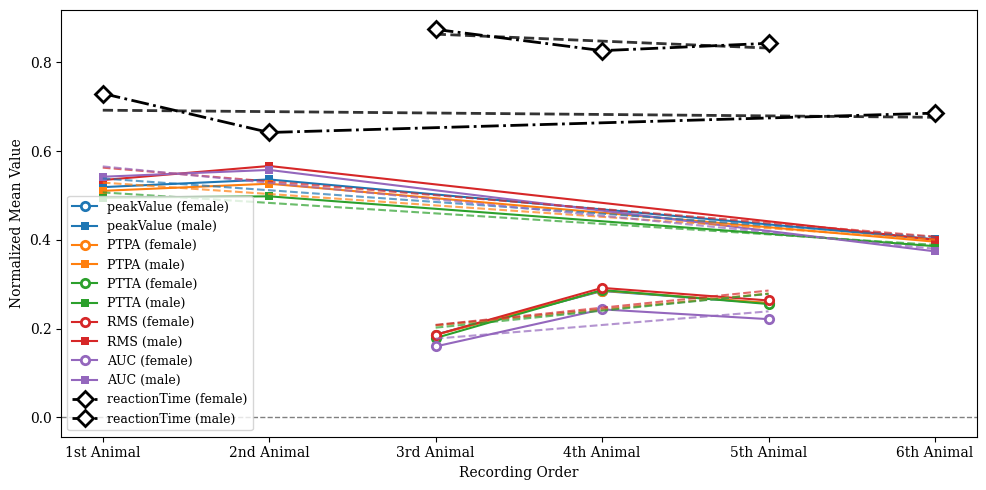

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

df = dfs['RESULTS_MERGED']
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}
orders = np.arange(1, 7)
sexes = df['sex'].unique()

strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'AUC']
reaction_metrics = ['reactionTime']
all_metrics = strength_metrics + reaction_metrics

df_plot = df.copy()
if 'AUC' in df_plot.columns:
    df_plot['AUC'] = df_plot['AUC'] / 100

# Normalize each metric to [-1, 1] across all data
for metric in all_metrics:
    vals = df_plot[metric].dropna()
    if len(vals) > 0:
        max_abs = np.max(np.abs(vals))
        if max_abs != 0:
            df_plot[metric] = df_plot[metric] / max_abs

color_cycle = cycle(plt.cm.tab10.colors)
metric_color_map = {}
for metric in all_metrics:
    if metric not in metric_color_map:
        metric_color_map[metric] = next(color_cycle)

# ...existing code...

# Make reactionTime more visually distinct (use red, but not as drastic as black/yellow)
reactiontime_style = {
    'color': 'black',           # red line and marker
    'linestyle': '-.',
    'linewidth': 2,
    'marker': 'D',            # diamond
    'markersize': 8,
    'markerfacecolor': 'white',
    'markeredgecolor': 'black',
    'markeredgewidth': 2
}

fig, ax = plt.subplots(figsize=size)
trendline_slopes = []

for metric in all_metrics:
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{metric} ({sex})"
        if metric == 'reactionTime':
            # Use distinct style for reactionTime (red, but not as drastic)
            ax.plot(valid_orders, valid_means,
                    label=label,
                    color=reactiontime_style['color'],
                    linestyle=reactiontime_style['linestyle'],
                    linewidth=reactiontime_style['linewidth'],
                    marker=reactiontime_style['marker'],
                    markersize=reactiontime_style['markersize'],
                    markerfacecolor=reactiontime_style['markerfacecolor'],
                    markeredgecolor=reactiontime_style['markeredgecolor'],
                    markeredgewidth=reactiontime_style['markeredgewidth'],
                    zorder=10)
        else:
            color = metric_color_map[metric]
            marker = 'o' if sex == 'female' else 's'
            ax.plot(valid_orders, valid_means, marker=marker, color=color, label=label,
                    markerfacecolor='white' if sex == 'female' else color,
                    markeredgewidth=2 if sex == 'female' else 0,
                    markeredgecolor=color if sex == 'female' else color,
                    linestyle='-', zorder=1)

        # Trendline per metric/sex
        if len(valid_orders) > 1:
            z = np.polyfit(valid_orders, valid_means, 1)
            p = np.poly1d(z)
            if metric == 'reactionTime':
                ax.plot(valid_orders, p(valid_orders),
                        color=reactiontime_style['color'],
                        linestyle='--',
                        linewidth=2,
                        alpha=0.8)
            else:
                ax.plot(valid_orders, p(valid_orders),
                        color=metric_color_map[metric], linestyle='--', linewidth=1.5, alpha=0.7)
            trendline_slopes.append({
                'metric': metric,
                'sex': sex,
                'slope': z[0]
            })

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
# ...existing code...
def ordinal(n):
    n = int(n)
    if 10 <= (n % 100) <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

ax.set_xticks(orders)
ax.set_xticklabels([f"{ordinal(i)} Animal" for i in orders])
ax.set_xlabel('Recording Order')
ax.set_ylabel('Normalized Mean Value')
# ...existing code...
ax.legend(fontsize=9)
# ...existing code...
plt.tight_layout()


print("Trendline slopes (per metric and sex):")
for t in trendline_slopes:
    print(f"{t['metric']} | {t['sex']}: slope = {t['slope']:.4f}")
# ...existing code...



# ...existing code...
import os
import matplotlib as mpl

export_folder = r"C:\Users\Galahad\Desktop\Thesis\images"
os.makedirs(export_folder, exist_ok=True)

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": False,
    "pgf.rcfonts": False,
})

def sanitize_figure_for_pgf(fig):
    """Remove/escape characters that break LaTeX PGF: replace '_' with space, escape '%'."""
    def _sanitize(s):
        if not isinstance(s, str):
            return s
        s = s.replace('_', ' ')
        s = s.replace('%', r'\%')   # escape percent for LaTeX
        return s

    # sanitize all Text instances (titles, ticklabels, axis labels, annotations ...)
    from matplotlib.text import Text
    for txt in fig.findobj(Text):
        try:
            txt.set_text(_sanitize(txt.get_text()))
        except Exception:
            pass

    # sanitize Line2D labels (legend labels come from these)
    for line in fig.findobj(mpl.lines.Line2D):
        lab = line.get_label()
        if isinstance(lab, str) and not lab.startswith('_'):
            try:
                line.set_label(_sanitize(lab))
            except Exception:
                pass

    # sanitize legend texts explicitly
    for ax in fig.axes:
        leg = ax.get_legend()
        if leg is not None:
            for t in leg.get_texts():
                try:
                    t.set_text(_sanitize(t.get_text()))
                except Exception:
                    pass

    # redraw so changes stick
    try:
        fig.canvas.draw()
    except Exception:
        pass

# get the actual figure object that we plotted on
fig = plt.gcf()       # or fig = ax.get_figure() if you have ax

# Make sure axis labels don't contain raw percent/underscores visually
try:
    ax = fig.axes[0]
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace('%', r'\%'))
    ax.set_xlabel(ax.get_xlabel().replace('_', ' '))
except Exception:
    pass

# sanitize and save
sanitize_figure_for_pgf(fig)

basename = "rec_order"
pgf_path = os.path.join(export_folder, f"{basename}.pgf")
pdf_path = os.path.join(export_folder, f"{basename}.pdf")

try:
    fig.savefig(pgf_path, format="pgf", bbox_inches="tight")
    print(f"Saved PGF: {pgf_path}")
    # quick sanity checks
    try:
        sz = os.path.getsize(pgf_path)
        print(f"PGF size: {sz} bytes")
        with open(pgf_path, 'r', encoding='utf-8', errors='replace') as fh:
            for _ in range(6):
                print(fh.readline().rstrip())
    except Exception as _e:
        print("Could not inspect PGF file:", _e)
except Exception as e:
    print(f"PGF save failed ({e}), saving PDF instead.")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved PDF: {pdf_path}")
# ...existing code...
# ...existing code...
plt.show()
# ...existing code...

Saved PGF: C:\Users\Galahad\Desktop\Thesis\images\rec_order_ASR_control.pgf


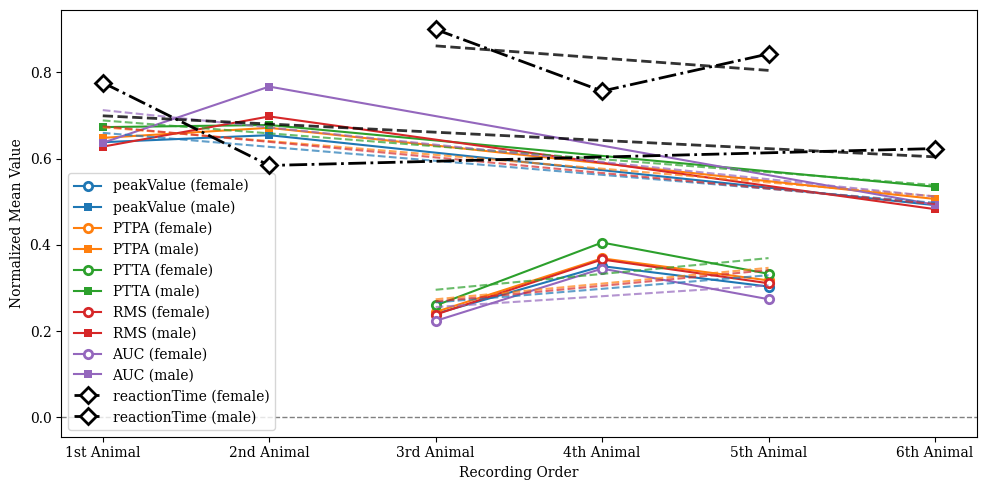

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Take only ASR_control experiments from RESULTS_MERGED.xlsx
df = pd.read_excel(r'[2] Analyzer Results/RESULTS_MERGED.xlsx')
df_asr = df[df['experiment'] == 'ASR_control'].copy()

recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}
orders = np.arange(1, 7)
sexes = df_asr['sex'].unique()

strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'AUC']
reaction_metrics = ['reactionTime']
all_metrics = strength_metrics + reaction_metrics

df_plot = df_asr.copy()
if 'AUC' in df_plot.columns:
    df_plot['AUC'] = df_plot['AUC'] / 100

# Normalize each metric to [-1, 1] across all ASR_control data
for metric in all_metrics:
    vals = df_plot[metric].dropna()
    if len(vals) > 0:
        max_abs = np.max(np.abs(vals))
        if max_abs != 0:
            df_plot[metric] = df_plot[metric] / max_abs

color_cycle = cycle(plt.cm.tab10.colors)
metric_color_map = {}
for metric in all_metrics:
    if metric not in metric_color_map:
        metric_color_map[metric] = next(color_cycle)

reactiontime_style = {
    'color': 'black',
    'linestyle': '-.',
    'linewidth': 2,
    'marker': 'D',
    'markersize': 8,
    'markerfacecolor': 'white',
    'markeredgecolor': 'black',
    'markeredgewidth': 2
}

fig, ax = plt.subplots(figsize=size)
trendline_slopes = []

for metric in all_metrics:
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{metric} ({sex})"
        if metric == 'reactionTime':
            ax.plot(valid_orders, valid_means,
                    label=label,
                    color=reactiontime_style['color'],
                    linestyle=reactiontime_style['linestyle'],
                    linewidth=reactiontime_style['linewidth'],
                    marker=reactiontime_style['marker'],
                    markersize=reactiontime_style['markersize'],
                    markerfacecolor=reactiontime_style['markerfacecolor'],
                    markeredgecolor=reactiontime_style['markeredgecolor'],
                    markeredgewidth=reactiontime_style['markeredgewidth'],
                    zorder=10)
        else:
            color = metric_color_map[metric]
            marker = 'o' if sex == 'female' else 's'
            ax.plot(valid_orders, valid_means, marker=marker, color=color, label=label,
                    markerfacecolor='white' if sex == 'female' else color,
                    markeredgewidth=2 if sex == 'female' else 0,
                    markeredgecolor=color if sex == 'female' else color,
                    linestyle='-', zorder=1)

        # Trendline per metric/sex
        if len(valid_orders) > 1:
            z = np.polyfit(valid_orders, valid_means, 1)
            p = np.poly1d(z)
            if metric == 'reactionTime':
                ax.plot(valid_orders, p(valid_orders),
                        color=reactiontime_style['color'],
                        linestyle='--',
                        linewidth=2,
                        alpha=0.8)
            else:
                ax.plot(valid_orders, p(valid_orders),
                        color=metric_color_map[metric], linestyle='--', linewidth=1.5, alpha=0.7)
            trendline_slopes.append({
                'metric': metric,
                'sex': sex,
                'slope': z[0]
            })

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
# ...existing code...
def ordinal(n):
    n = int(n)
    if 10 <= (n % 100) <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

ax.set_xticks(orders)
ax.set_xticklabels([f"{ordinal(i)} Animal" for i in orders])
ax.set_xlabel('Recording Order')
ax.set_ylabel('Normalized Mean Value')
ax.legend()
# ...existing code...
# ...existing code...
plt.tight_layout()

# export PGF/PDF for this figure (ASR_control)
import os
import matplotlib as mpl

export_folder = r"C:\Users\Galahad\Desktop\Thesis\images"
os.makedirs(export_folder, exist_ok=True)

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": False,
    "pgf.rcfonts": False,
})

fig = plt.gcf()
basename = "rec_order_ASR_control"
pgf_path = os.path.join(export_folder, f"{basename}.pgf")
pdf_path = os.path.join(export_folder, f"{basename}.pdf")

try:
    fig.savefig(pgf_path, format="pgf", bbox_inches="tight")
    print(f"Saved PGF: {pgf_path}")
except Exception as e:
    print(f"PGF save failed ({e}), saving PDF instead.")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved PDF: {pdf_path}")

plt.show()
# ...existing code...


In [144]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                # Shapiro-Wilk normality test
                p_sw_early = shapiro(vals_early)[1] if len(vals_early) > 2 else 1.0
                p_sw_late = shapiro(vals_late)[1] if len(vals_late) > 2 else 1.0
                normal = p_sw_early > 0.05 and p_sw_late > 0.05
                if normal:
                    stat, p = ttest_ind(vals_early, vals_late, equal_var=False)
                    test_type = 'ttest_ind'
                    pooled_std = ((vals_early.std(ddof=1) ** 2 + vals_late.std(ddof=1) ** 2) / 2) ** 0.5
                    effect_strength = mean_diff / pooled_std if pooled_std != 0 else None
                else:
                    stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                    test_type = 'mannwhitneyu'
                    effect_strength = None
                if p < 0.05:
                    results.append({
                        'sex': sex,
                        'date': date,
                        'variable': var,
                        'test': test_type,
                        'stat': stat,
                        'p': p,
                        'shapiro_p_early': p_sw_early,
                        'shapiro_p_late': p_sw_late,
                        'effect_strength': effect_strength,
                        'mean_diff': mean_diff
                    })

rec_order_test_df = pd.DataFrame(results)
print(rec_order_test_df)
rec_order_test_df.to_excel(os.path.join(output_dir, "RECORDER_ORDER_EFFECT_ALL_VARIABLES.xlsx"), index=False)

       sex     date      variable          test        stat             p  \
0   female  April16           AUC  mannwhitneyu  178.000000  2.724844e-02   
1   female   June26     peakValue     ttest_ind   -2.756230  8.389837e-03   
2   female   June26          PTPA     ttest_ind   -2.905711  5.656445e-03   
3   female   June26          PTTA  mannwhitneyu  178.000000  2.724844e-02   
4   female    May20           AUC     ttest_ind   -2.205298  3.290691e-02   
5     male  April16     peakValue     ttest_ind    5.310821  2.883219e-06   
6     male  April16          PTPA     ttest_ind    5.210297  4.014292e-06   
7     male  April16          PTTA     ttest_ind    4.941858  1.058144e-05   
8     male  April16           RMS  mannwhitneyu  476.000000  1.941390e-04   
9     male  April16           AUC     ttest_ind    5.711762  9.024302e-07   
10    male   June26  reactionTime  mannwhitneyu  444.500000  1.907865e-03   
11    male   June26     peakValue     ttest_ind   15.549661  1.561349e-20   

---

Fraction of non-normal variables: 1.00
Using spearman correlation for all variable pairs.
Saved PGF: C:\Users\Galahad\Desktop\Thesis\images\correlations.pgf


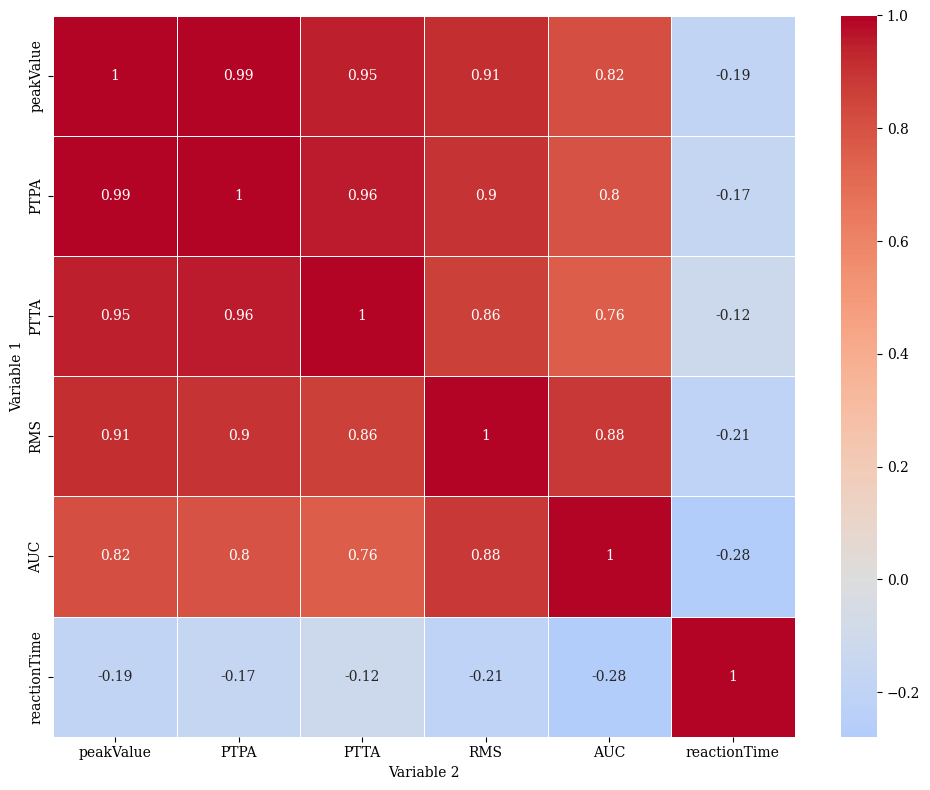

In [162]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

# Check normality for each variable (pooled)
non_normal_count = 0
for var in variables:
    vals = df[var].dropna()
    if len(vals) > 2:
        p_sw = shapiro(vals)[1]
        if p_sw < 0.05:
            non_normal_count += 1
fraction_non_normal = non_normal_count / len(variables)
print(f"Fraction of non-normal variables: {fraction_non_normal:.2f}")

# Decide test type
if fraction_non_normal > 0.3:
    corr_func = spearmanr
    corr_type = 'spearman'
else:
    corr_func = pearsonr
    corr_type = 'pearson'
print(f"Using {corr_type} correlation for all variable pairs.")

results = []
for exp in df['experiment'].unique():
    for sex in df['sex'].unique():
        for date in df['date'].unique():
            df_sub = df[(df['experiment'] == exp) & (df['sex'] == sex) & (df['date'] == date)]
            if len(df_sub) < 3:
                continue
            for i, var1 in enumerate(variables):
                for var2 in variables[i+1:]:
                    merged = df_sub[[var1, var2]].dropna()
                    if len(merged) < 3:
                        continue
                    v1 = merged[var1]
                    v2 = merged[var2]
                    # Skip constant arrays
                    if len(set(v1)) < 2 or len(set(v2)) < 2:
                        continue
                    corr, p = corr_func(v1, v2)
                    results.append({
                        'experiment': exp,
                        'sex': sex,
                        'date': date,
                        'var1': var1,
                        'var2': var2,
                        'corr': corr,
                        'p': p,
                        'type': corr_type
                    })

# ...existing code...
cor_df = pd.DataFrame(results)


# ...existing code...

# Pivot to matrix for plotting (average across all experiment/sex/date groups)
# ...existing code...
pivoted = []
for _, group in cor_df.groupby(['experiment', 'sex', 'date']):
    # use NaN for missing pairs so np.nanmean ignores them
    mat = pd.DataFrame(np.nan, index=variables, columns=variables, dtype=float)
    for _, row in group.iterrows():
        mat.loc[row['var1'], row['var2']] = row['corr']
        mat.loc[row['var2'], row['var1']] = row['corr']
    np.fill_diagonal(mat.values, 1.0)
    pivoted.append(mat)

# average only over available group entries
avg_corr = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)
avg_corr_df = pd.DataFrame(avg_corr, index=variables, columns=variables)
# ...existing code...
# ...existing code...

# Calculate average positive correlation for each variable
# ...existing code...
# Calculate average positive correlation for each variable
avg_corr_pos = pd.Series(
    {var: avg_corr_df.loc[var][avg_corr_df.loc[var] > 0].mean() for var in avg_corr_df.index}
).sort_values(ascending=False)

# Reorder variables by average positive correlation but force the requested metrics first
requested_first = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'AUC','reactionTime']
# keep only those present in the data
requested_first = [v for v in requested_first if v in avg_corr_df.index]

# remaining variables in the order of avg_corr_pos
remaining = [v for v in avg_corr_pos.index if v not in requested_first]

sorted_vars = requested_first + remaining
avg_corr_df_sorted = avg_corr_df.loc[sorted_vars, sorted_vars]

# ...existing code...

plt.figure(figsize=(10, 8))
sns.heatmap(avg_corr_df_sorted, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.ylabel("Variable 1")
plt.xlabel("Variable 2")
plt.tight_layout()

# export PGF/PDF for this heatmap
import os
import matplotlib as mpl

export_folder = r"C:\Users\Galahad\Desktop\Thesis\images"
os.makedirs(export_folder, exist_ok=True)

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": False,
    "pgf.rcfonts": False,
})

fig = plt.gcf()
basename = "correlations"
pgf_path = os.path.join(export_folder, f"{basename}.pgf")
pdf_path = os.path.join(export_folder, f"{basename}.pdf")

try:
    fig.savefig(pgf_path, format="pgf", bbox_inches="tight")
    print(f"Saved PGF: {pgf_path}")
except Exception as e:
    print(f"PGF save failed ({e}), saving PDF instead.")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved PDF: {pdf_path}")

plt.show()
# ...existing code...

---